In [1]:
!pip install --upgrade pymupdf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 75.2 MB/s eta 0:00:00


# OpenAI API

In [6]:
MAX_CHARS = 12000

In [9]:
import fitz  # PyMuPDF
from openai import OpenAI
import re
import json
import os

# ✅ Load API Key
OPENAI_API_KEY = ""
client = OpenAI(api_key=OPENAI_API_KEY)

# ✅ Extract raw text with PyMuPDF
def extract_text_pymupdf(pdf_path):
    doc = fitz.open(pdf_path)
    return "\n".join(page.get_text() for page in doc)

# ✅ Clean up GPT response
def extract_json_from_gpt(raw_text):
    cleaned = re.sub(r"```json|```", "", raw_text).strip()
    return cleaned

def gpt_extract_food_counts_with_calories(menu_text):
    menu_text = menu_text[:MAX_CHARS]
    prompt = f"""
You are a nutritionist reviewing a weekly school menu written in Portuguese. The menu may include foods served to children in nurseries, preschools, or elementary schools. Your job is to identify each food item and estimate its calorie content per standard child-sized portion.

**Important: Always estimate the calories based on typical preparation methods in Brazil, even if not explicitly stated. Never return "0 kcal". Use common sense and nutrition knowledge.**

Your output should be a single JSON dictionary. Each key must follow this format:
**"food name (XXX kcal)"**
Where `XXX` is your estimated number of kilocalories per serving.

Each value in the dictionary should be the number of times that food appears in the text.

Guidelines:
- Keep food names in Portuguese (e.g., "arroz", "feijão", "suco de maçã")
- Calorie values must be realistic estimates (e.g., "arroz (40 kcal)")
- Distinguish similar items (e.g., "suco de maçã" vs "suco de uva")
- Count all appearances; no duplicates
- Output only valid JSON (no markdown or explanation)
- An Item can never be 0 Calories because that is not possible

Here is the menu:
{menu_text}
"""


    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Você é um especialista em nutrição infantil."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
        )

        reply = response.choices[0].message.content.strip()
        cleaned = extract_json_from_gpt(reply)

        try:
            return json.loads(cleaned)
        except json.JSONDecodeError:
            print("⚠️ GPT returned invalid JSON:")
            print(reply)
            return {}

    except Exception as e:
        print(f"Error during GPT call: {e}")
        return {}



In [4]:
# ✅ Batch process all PDFs in the folder
folder_path = "/content/drive/MyDrive/PNAE Gen AI Project/Menus for the State Alagoas"
results_by_file = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(folder_path, filename)
        print(f"\n📄 Processing: {filename}")

        try:
            raw_text = extract_text_pymupdf(pdf_path)
            cleaned_text = remove_reported_totals(raw_text)
            result = gpt_extract_food_counts_with_calories(cleaned_text)
            results_by_file[filename] = result

            # Optional: print result
            for item, count in result.items():
                print(f"{item}: {count}x")

        except Exception as e:
            print(f"⚠️ Failed on {filename}: {e}")

# ✅ Optionally save all results to JSON
with open("district_food_summary.json", "w", encoding="utf-8") as f:
    json.dump(results_by_file, f, ensure_ascii=False, indent=2)

print("\n✅ Done processing all PDFs.")


📄 Processing: SETEMBRO-BERCARIO(3).pdf
⚠️ Failed on SETEMBRO-BERCARIO(3).pdf: name 'remove_reported_totals' is not defined

📄 Processing: SETEMBRO-EF-INTEGRAL.pdf


KeyboardInterrupt: 

# Rio de Janeiro Findings

In [11]:
# ✅ Batch process all PDFs in the folder
folder_path = "/content/drive/MyDrive/PNAE Gen AI Project/Menus for Rio De Janerio"
results_Rio_de_Janeiro = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(folder_path, filename)
        print(f"\n📄 Processing: {filename}")

        try:
            raw_text = extract_text_pymupdf(pdf_path)
            result = gpt_extract_food_counts_with_calories(raw_text)
            results_Rio_de_Janeiro[filename] = result

            # Optional: print result
            for item, count in result.items():
                print(f"{item}: {count}x")

        except Exception as e:
            print(f"⚠️ Failed on {filename}: {e}")


📄 Processing: Cardapio-Publicacao-DO-periodo-INVERNO-2025.pdf
Leite batido com banana e aveia (36 kcal): 36x
Arroz (130 kcal): 48x
Feijão (90 kcal): 48x
Ovo mexido ou omelete (90 kcal): 12x
Chuchu com vagem sauté (30 kcal): 12x
Sobr. fruta (60 kcal): 72x
Leite com café (30 kcal): 12x
Cuscuz de Tapioca (150 kcal): 12x
Pão com manteiga (150 kcal): 24x
Peixe (gratinado com aipim) (200 kcal): 12x
Salada de cenoura ralada com tomate (40 kcal): 12x
Frango oriental (cenoura, abobrinha e couve-flor) (180 kcal): 12x
Batata sauté (120 kcal): 12x
Leite batido com banana (90 kcal): 12x
Arroz com cenoura (140 kcal): 12x
Estrogonofe de frango (200 kcal): 12x
Purê de batata doce (120 kcal): 12x
Frango ensopado (180 kcal): 12x
Leite batido com abacate (120 kcal): 12x
Frango à caçadora (frango com cenoura) (190 kcal): 12x
Aipim sauté (130 kcal): 12x
Carne colorida (carne, cenoura e ovo) (220 kcal): 12x
Batata doce assada (150 kcal): 12x
Isca de fígado (180 kcal): 12x
Purê de batata (120 kcal): 12x
Fus

# Espirito Santos Findings

## Nursuries

# State of Parana Findings

In [12]:
# ✅ Batch process all PDFs in the folder
folder_path = "/content/drive/MyDrive/PNAE Gen AI Project/Menus for Curitiba"
results_Curitiba = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(folder_path, filename)
        print(f"\n📄 Processing: {filename}")

        try:
            raw_text = extract_text_pymupdf(pdf_path)
            result = gpt_extract_food_counts_with_calories(raw_text)
            results_Curitiba[filename] = result

            # Optional: print result
            for item, count in result.items():
                print(f"{item}: {count}x")

        except Exception as e:
            print(f"⚠️ Failed on {filename}: {e}")


📄 Processing: 00519711.pdf
SAGU DE UVA (150 kcal): 4x
CREME DE LEITE (20 kcal): 4x
BANANA (130 kcal): 8x
SUCO POLPA DE ACEROLA (200 kcal): 4x
PÃO DE MILHO (50 kcal): 4x
CARNE MOÍDA PARA PÃO (60 kcal): 4x
SUCO POLPA DE MAÇÃ (200 kcal): 4x
SANDUÍCHE NATURAL (100 kcal): 4x
MACARRÃO PARAFUSO (100 kcal): 8x
MOLHO DE CARNE E ABÓBORA (50 kcal): 4x
MELÃO FATIADO (150 kcal): 8x
SOPA DE ARROZ COM FRANGO, BATATA E CENOURA (150 kcal): 8x
MAÇÃ (100 kcal): 8x
SUCO POLPA DE UVA (200 kcal): 16x
BOLO DE MAÇÃ, AVEIA E CANELA (50 kcal): 8x
ARROZ (40 kcal): 20x
ISCAS DE CARNE E CENOURA (60 kcal): 8x
SUCO POLPA DE ABACAXI (200 kcal): 4x
PÃO DE LEITE (50 kcal): 8x
CACHORRO QUENTE (70 kcal): 8x
SOPA DE ARROZ COM CARNE, BATATA E COUVE (150 kcal): 8x
SUCO POLPA DE MANGA (200 kcal): 4x
PÃO DE AVEIA (50 kcal): 8x
FRANGO PARA PÃO COM TOMATE (60 kcal): 8x
CANJICA (200 kcal): 4x
POLENTA (100 kcal): 8x
ISCAS DE FRANGO REFOGADA COM BRÓCOLIS (60 kcal): 8x
KIWI (80 kcal): 8x
RISOTO DE CARNE E ABÓBORA (150 kcal): 8x
PO

# Menus for Pernambuco

# Menus for Rio Grande do Sul

In [13]:
# ✅ Batch process all PDFs in the folder
folder_path = "/content/drive/MyDrive/PNAE Gen AI Project/Menus for Rio Grande De Sul"
results_Rio_Sul = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(folder_path, filename)
        print(f"\n📄 Processing: {filename}")

        try:
            raw_text = extract_text_pymupdf(pdf_path)
            result = gpt_extract_food_counts_with_calories(raw_text)
            results_Rio_Sul[filename] = result

            # Optional: print result
            for item, count in result.items():
                print(f"{item}: {count}x")

        except Exception as e:
            print(f"⚠️ Failed on {filename}: {e}")


📄 Processing: jp_fev.pdf
arroz (150 kcal): 5x
feijão (100 kcal): 5x
frango grelhado (200 kcal): 3x
purê de batata (120 kcal): 4x
salada de alface e tomate (50 kcal): 5x
suco de laranja (80 kcal): 5x
bife acebolado (250 kcal): 3x
macarrão ao sugo (180 kcal): 4x
legumes cozidos (70 kcal): 5x

📄 Processing: ber_fev.pdf
arroz (150 kcal): 5x
feijão (100 kcal): 5x
frango grelhado (200 kcal): 3x
purê de batata (120 kcal): 4x
salada de alface e tomate (50 kcal): 5x
macarrão ao sugo (180 kcal): 3x
peixe assado (180 kcal): 2x
legumes cozidos (70 kcal): 4x
suco de laranja (80 kcal): 5x
banana (100 kcal): 5x
pão de queijo (150 kcal): 3x

📄 Processing: fund_fev.pdf
arroz (150 kcal): 5x
feijão (100 kcal): 5x
frango grelhado (200 kcal): 3x
purê de batata (120 kcal): 4x
salada de alface e tomate (50 kcal): 5x
macarrão com molho de tomate (180 kcal): 4x
peixe assado (180 kcal): 2x
legumes cozidos (70 kcal): 4x
suco de laranja (80 kcal): 5x
banana (100 kcal): 5x
iogurte natural (60 kcal): 5x
pão integr

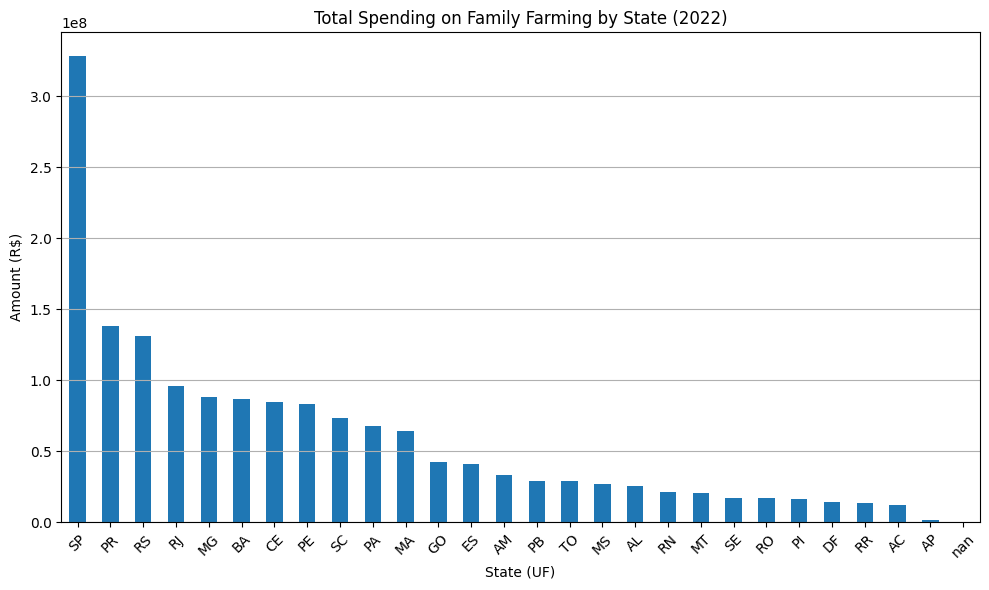

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

spending_df = pd.read_excel("/content/drive/MyDrive/PNAE Gen AI Project/Planilha2022_04_3_24.xlsx")

# Clean and rename columns
df_cleaned = spending_df.iloc[1:].copy()
df_cleaned.columns = spending_df.iloc[0]
df_cleaned = df_cleaned.dropna(subset=['Valor aquisições da agricultura familiar'])

# Convert relevant columns to numeric
df_cleaned['Valor aquisições da agricultura familiar'] = pd.to_numeric(
    df_cleaned['Valor aquisições da agricultura familiar'], errors='coerce')
df_cleaned['UF'] = df_cleaned['UF'].astype(str)

# Aggregate spending by state (UF)
state_agg = df_cleaned.groupby('UF')['Valor aquisições da agricultura familiar'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
state_agg.plot(kind='bar')
plt.title('Total Spending on Family Farming by State (2022)')
plt.xlabel('State (UF)')
plt.ylabel('Amount (R$)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()